#### Bag-of-Words 
- A simple discrete representation of text. Bag of word model processes the text to find how many times each word appeared in the sentence. 
- Steps for creating BOW
    - Tokenize the text into sentences
    - Tokenize sentences into words
    - Remove punctuation or stop words (a, the, ...)
    - Convert the words to lower text
    - Create the frequency distribution of words

In [1]:
from pathlib import Path

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from google_drive_downloader import GoogleDriveDownloader as gdd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm, tqdm_notebook

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

In [4]:
pd.set_option('max_colwidth',150)

In [5]:
# View some example records
reviews = pd.read_csv(DATA_PATH)
reviews.sample(10)

,review,label
22797,"This is an excellent film. No, it's not Mel Gibson in ""Braveheart,"" but then, it's not trying to be. Actually, ""The Emperor and the Assassin"" prob...",1
49172,"On first watching this film it is hard to know quite what has happened, but on a subsequent viewing it become more clear. I enjoyed this movie. De...",1
33167,"Absolute garbage, worse fight scenes than a 20 year old van damme movie or American ninja etc.<br /><br />Truly dire acting, not a skill in sight ...",0
39248,This movies chronicles the life and times of William Castle. He made a series of low budget horror films in the 1950s-1960s that he sold with gimm...,1
50326,Arnold once again in the 80's demonstrated that he was the king of action and one liners in this futuristic film about a violent game show that no...,1
38108,I was really excited about seeing this film. I thought finally Australia had made a good film.. but I was wrong.<br /><br />This was the most path...,1
11190,"This movie is too stupid for words. Even if you consider it to be a parody on movie-making, if you consider it to be completely camp, even than yo...",0
45262,shakespeare's plays have a way of transcending time. The language somehow breaks the time barrier. but perhaps it is the actors who really do that...,1
61924,"This film was slated to be a blockbuster film, and it really is. This is the type of movie that is made to eat popcorn to and watch the flashy gra...",0
1879,"Having just watched Acacia, I find that I have to agree with the negative reviews here. I like Asian, and Korean horror, and I had great expectati...",0


#### Bag-of-Words representation
- So the final bag-of-words vector for ['the', 'gray', 'cat', 'sat', 'on', 'the', 'gray', 'mat'] is [0, 1, 1, 2, 2, 1, 0, 1]

<img src=attachment:image.png width=350>
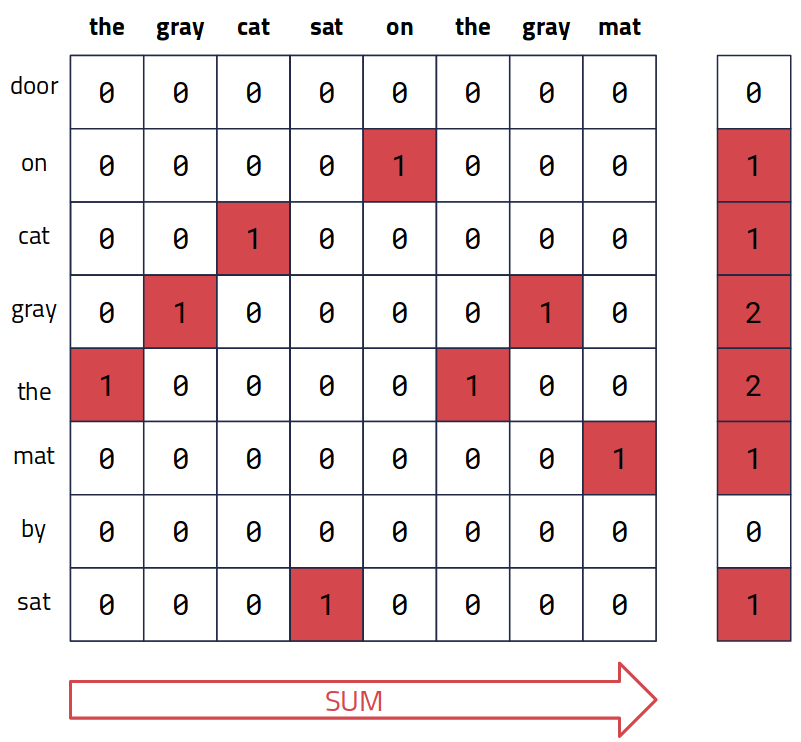

In [6]:
review_docu = reviews.review.tolist()

In [7]:
review_docu[:2]

["Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.",
 "This is an example of why the majority of action films are the same. Generic and boring, ther

##### sklearn CountVectorizer
- Convert a collection of text documents to a matrix of token counts
- This implementation produces a sparse representation of the counts

In [8]:
vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.005)

In [9]:
sequence = vectorizer.fit_transform(review_docu[:2])

In [10]:
sequence[0,:].toarray()

array([[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0,
        2, 1, 1, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 3, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0]])

In [11]:
class Sequences(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        self.vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.005)
        self.sequences = self.vectorizer.fit_transform(df.review.tolist())
        self.labels = df.label.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [12]:
dataset = Sequences(DATA_PATH)
train_loader = DataLoader(dataset, batch_size=4096)

print(dataset[5][0].shape)

(1, 3028)


In [13]:
class BagOfWordsClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super(BagOfWordsClassifier, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [14]:
len(dataset.token2idx)

3028

In [15]:
model = BagOfWordsClassifier(len(dataset.token2idx), 128, 64).to(device)

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

##### Training

In [17]:
model.train()
for epoch in range(10):
    total = 0
    for inputs, target in train_loader:
        
        inputs = inputs.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output.squeeze(), target.float())        
        loss.backward()                      
        optimizer.step()                        
    
    print('epoch: ', epoch, 'loss: ', loss.item())      
    

epoch:  0 loss:  0.6807875037193298
epoch:  1 loss:  0.6502506732940674
epoch:  2 loss:  0.592934787273407
epoch:  3 loss:  0.5124715566635132
epoch:  4 loss:  0.41513997316360474
epoch:  5 loss:  0.32662084698677063
epoch:  6 loss:  0.2648095190525055
epoch:  7 loss:  0.22314424812793732
epoch:  8 loss:  0.19353929162025452
epoch:  9 loss:  0.17136335372924805


In [18]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor(dataset.vectorizer.transform([text]).toarray()).to(device)

        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            print(f'{prediction:0.3}: Positive sentiment')
        else:
            print(f'{prediction:0.3}: Negative sentiment')

In [19]:
test_text = """
Especially one with so many twists and turns that the best writing about it will be long after spoiler warnings aren’t needed? 
I’ll do my best because Bong Joon-ho’s “Parasite” is unquestionably one of the best films of the year. Just trust me on this one.
"""
predict_sentiment(test_text)

0.715: Positive sentiment


In [20]:
test_text = """
Cool Cat Saves The Kids is a symbolic masterpiece directed by Derek Savage that
is not only satirical in the way it makes fun of the media and politics, but in
the way in questions as how we humans live life and how society tells us to
live life.

Before I get into those details, I wanna talk about the special effects in this
film. They are ASTONISHING, and it shocks me that Cool Cat Saves The Kids got
snubbed by the Oscars for Best Special Effects. This film makes 2001 look like
garbage, and the directing in this film makes Stanley Kubrick look like the
worst director ever. You know what other film did that? Birdemic: Shock and
Terror. Both of these films are masterpieces, but if I had to choose my
favorite out of the 2, I would have to go with Cool Cat Saves The Kids. It is
now my 10th favorite film of all time.

Now, lets get into the symbolism: So you might be asking yourself, Why is Cool
Cat Orange? Well, I can easily explain. Orange is a color. Orange is also a
fruit, and its a very good fruit. You know what else is good? Good behavior.
What behavior does Cool Cat have? He has good behavior. This cannot be a
coincidence, since cool cat has good behavior in the film.
"""
predict_sentiment(test_text)

0.904: Positive sentiment


In [21]:
test_text = """
What the heck is this ? There is not one redeeming quality about this terrible
and very poorly done "movie". I can't even say that it's a "so bad it's good
movie".It is undeniably pointless to address all the things wrong here but
unfortunately even the "life lessons" about bullies and stuff like this are so
wrong and terrible that no kid should hear them.The costume is also horrible
and the acting...just unbelievable.
"""
predict_sentiment(test_text)

0.00847: Negative sentiment
